In [2]:
import ROOT as root
import numpy as np

np.random.seed(1234)



In [3]:

def getDataFromFile(fileinfo, branchlist) :

  tfil = root.TFile(fileinfo)
  tree = tfil.Get('flatTree')
  datasize = tree.GetEntriesFast()
  
  print "Reading NN inputs from " + fileinfo
  data = np.empty([datasize, len(branchlist)])
  counter = 0
  for entry in tree :
    bridx = 0
    for branch in branchlist :
      data[counter][bridx] = getattr(entry, branch)
      bridx = bridx + 1

    counter = counter + 1
  
  tfil.Close()

  return data




def getDataFromFileWithCut(fileinfo, branchlist, cut_variable, cut_value) :

  tfil = root.TFile(fileinfo)
  tree = tfil.Get('flatTree')
  
  datasize = tree.GetEntries(cut_variable + " == " +  str(cut_value))
  
  print "Reading NN inputs from " + fileinfo
  data = np.empty([datasize, len(branchlist)])
  counter = 0
  for entry in tree :
    bridx = 0
    
    # check cut
    if getattr(entry, cut_variable) == cut_value :
    
      for branch in branchlist :
        data[counter][bridx] = getattr(entry, branch)
          
        bridx = bridx + 1
     
      counter = counter + 1
  
  tfil.Close()

  print " counter = ", counter 
  
  return data






def getDataFromFileWithCutGreater(fileinfo, branchlist, cut_variable, cut_value) :

  tfil = root.TFile(fileinfo)
  tree = tfil.Get('flatTree')

  datasize = tree.GetEntries(cut_variable + " >= " +  str(cut_value))
 
  print "Reading NN inputs from " + fileinfo
  data = np.empty([datasize, len(branchlist)])
  counter = 0
  for entry in tree :
    bridx = 0
    
    # check cut
    if getattr(entry, cut_variable) >= cut_value :
    
      for branch in branchlist :
        data[counter][bridx] = getattr(entry, branch)
        bridx = bridx + 1
     
      counter = counter + 1
  
  tfil.Close()

  print " counter = ", counter 
  
  return data


In [4]:

#######################################
#
# Start here
#

zllfile = 'flat_tree_Z.root'
 
brlist  = ['tk_dedxl0', 'tk_dedxl1', 'tk_dedxl2', 'tk_dedxl3', 'tk_dedxl4', 'tk_dedxl5', 'tk_dedxl6']
numvars = len(brlist)
ntrain  =  0.50   # 80% for train
ntest   =  1 - ntrain

print " brlist = ", brlist
data_bkg = getDataFromFileWithCutGreater (zllfile, brlist, 'tk_category', 1 )

print " bkg data.size = " , data_bkg.size , " ---> ", data_bkg.size/numvars

datasize_bkg = data_bkg.size/numvars

print "Splitting data between " + str(int(len(data_bkg)*ntrain)) + " training and " + str(int(len(data_bkg)*ntest)) + " testing samples bkg ..."

data_bkg_train = data_bkg[ : int(len(data_bkg)*ntrain) ]
data_bkg_test  = data_bkg[ int(len(data_bkg)*ntrain) : ]

data_train = np.vstack( [ data_bkg_train] )
data_test  = np.vstack( [ data_bkg_test ] )


 brlist =  ['tk_dedxl0', 'tk_dedxl1', 'tk_dedxl2', 'tk_dedxl3', 'tk_dedxl4', 'tk_dedxl5', 'tk_dedxl6']
Reading NN inputs from flat_tree_Z.root
 counter =  70449
 bkg data.size =  493143  --->  70449
Splitting data between 35224 training and 35224 testing samples bkg ...


In [5]:
#
#
#
# Keras model
#
#

import matplotlib.pyplot as plt

from matplotlib import cm

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist

original_dim = numvars
intermediate_dim = 4
latent_dim = 7    # one for each layer ?
batch_size = 100
epochs = 50
epsilon_std = 1.0




Using TensorFlow backend.


In [6]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)



In [7]:

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [8]:

decoder = Sequential ([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
    ])



In [9]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)))

z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)


In [10]:

vae = Model ( inputs=[x, eps], outputs=x_pred)
vae.compile (optimizer='rmsprop', loss=nll)


In [11]:

# train the VAE 
x_train = data_train
x_test  = data_test


history = vae.fit(x_train,   # source
                  x_train,   # target --> autoencoder, then the target is the same as the input
                  shuffle = True,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_test, x_test))    # target = input also in the testing


Train on 35224 samples, validate on 35225 samples
Epoch 1/50
35224/35224 [==============================] - 2s 55us/step - loss: -14.8784 - val_loss: -62.6208
Epoch 2/50
35224/35224 [==============================] - 2s 44us/step - loss: -114.5975 - val_loss: -150.0599
Epoch 3/50
35224/35224 [==============================] - 1s 42us/step - loss: -163.5404 - val_loss: -172.0216
Epoch 4/50
35224/35224 [==============================] - 2s 46us/step - loss: -175.5442 - val_loss: -178.2500
Epoch 5/50
35224/35224 [==============================] - 2s 48us/step - loss: -179.4730 - val_loss: -180.8007
Epoch 6/50
35224/35224 [==============================] - 1s 42us/step - loss: -181.2942 - val_loss: -182.1019
Epoch 7/50
35224/35224 [==============================] - 1s 42us/step - loss: -182.3437 - val_loss: -182.9861
Epoch 8/50
35224/35224 [==============================] - 2s 44us/step - loss: -183.1109 - val_loss: -183.6704
Epoch 9/50
35224/35224 [==============================] - 2s 48u

2018-12-14 16:03:35.370147: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [12]:
encoder = Model(x, z_mu)



In [13]:

# display a plot of the latent space
z_test = encoder.predict(x_test, batch_size = batch_size)



In [14]:
print "z_test = ", z_test

print "x_test = ", x_test



z_test =  [[-3.8183315e-03 -6.6958275e-03 -8.2860112e-01 ... -1.7866209e-02
  -1.0036972e+00 -9.6974326e-03]
 [-4.7344691e-04 -4.7726231e-04 -6.8174958e-02 ...  5.8930367e-04
   7.3106492e-01  7.6122582e-04]
 [ 1.5416278e-03  1.5369179e-03 -8.3268404e-02 ... -2.4333924e-02
   6.5106869e-01  1.2498125e-02]
 ...
 [-1.2066453e-03 -1.9510621e-03 -9.7293079e-02 ...  1.1562340e-02
   7.4109399e-01 -4.3151304e-03]
 [-1.6697426e-04  1.3359077e-04 -6.1271548e-02 ... -4.4643357e-03
   7.1843386e-01  2.9751211e-03]
 [-1.5739105e-03 -2.6838658e-03 -1.1921960e-01 ...  1.6262807e-02
   7.2561669e-01 -6.7101009e-03]]
x_test =  [[ 3.09220743  2.91992331  2.75642848 ...  2.15135527 -1.
  -1.        ]
 [ 2.30208063  2.25768137  4.39406109 ... -1.         -1.
  -1.        ]
 [ 6.45768356  2.49957013  4.46570492 ... -1.         -1.
  -1.        ]
 ...
 [ 3.21668196  2.88433599  2.30361819 ... -1.         -1.
  -1.        ]
 [ 4.00258541  2.30555749  2.87209988 ... -1.         -1.
  -1.        ]
 [ 1.39788

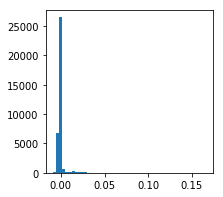

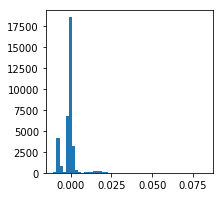

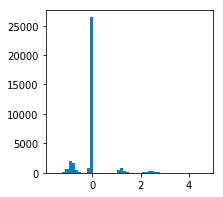

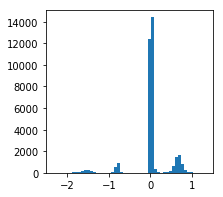

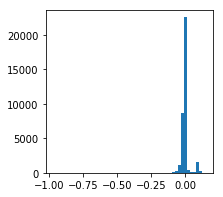

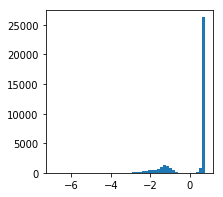

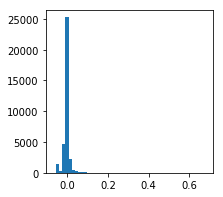

In [15]:
#plt.hist( z_test[:,0], bins = 50)
#plt.hist( x_test[:,0], bins = 50)



for inode in range(7):
  fig = plt.figure(inode, figsize = (3,3))
  plt.hist( z_test[:,inode], bins = 50)




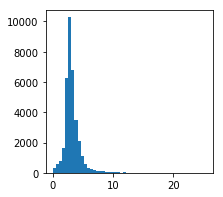

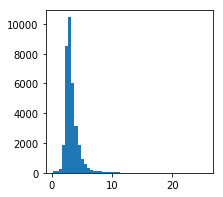

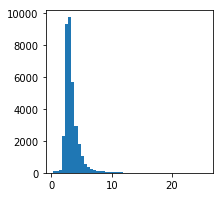

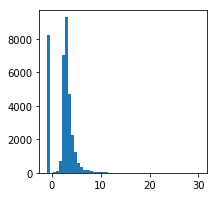

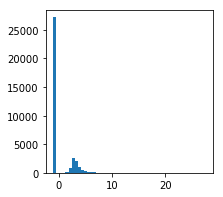

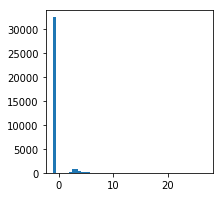

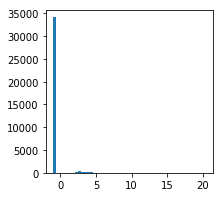

In [16]:


for inode in range(original_dim):
  fig = plt.figure(inode+7, figsize = (3,3))
  plt.hist( x_test[:,inode], bins = 50)


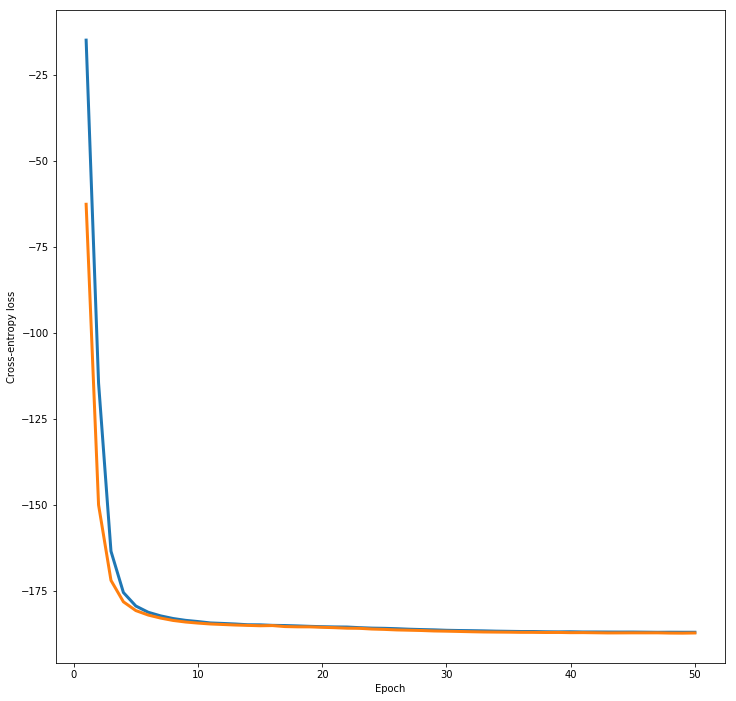

In [17]:


#########################################################
## validation plot

fig_validation = plt.figure(8+7, figsize=(12,12))

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Epoch"), plt.ylabel("Cross-entropy loss");



In [18]:

#########################################################
## plot structure of NN

from keras.utils import plot_model, print_summary
print_summary(vae)

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            32          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 7)            35          dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 7)            35          dense_3[0][0]                    
__________________________________________________________________________________________________
kl_diverge

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 0.09088472,  0.59578764,  1.10069057,  1.60559349,  2.11049641,
         2.61539934,  3.12030226,  3.62520519,  4.13010811,  4.63501104,
         5.13991396,  5.64481689,  6.14971981,  6.65462274,  7.15952566,
         7.66442859,  8.16933151,  8.67423444,  9.17913736,  9.68404029,
        10.18894321, 10.69384614, 11.19874906, 11.70365199, 12.20855491,
        12.71345784, 13.21836076, 13.72326369, 14.22816661, 14.73306954,
        15.23797246, 15.74287539, 16.24777831, 16.75268124, 17.25758416,
        17.76248709, 18.26739001, 18.77229294, 19.27719586, 19.78209879,
        20.28700171, 20.79190464, 21.29680756, 21.80171049, 22.30661341,
        22.81151634, 23.31641926, 23.82132219, 24.32622511, 24.83112804,
        25.33603096])

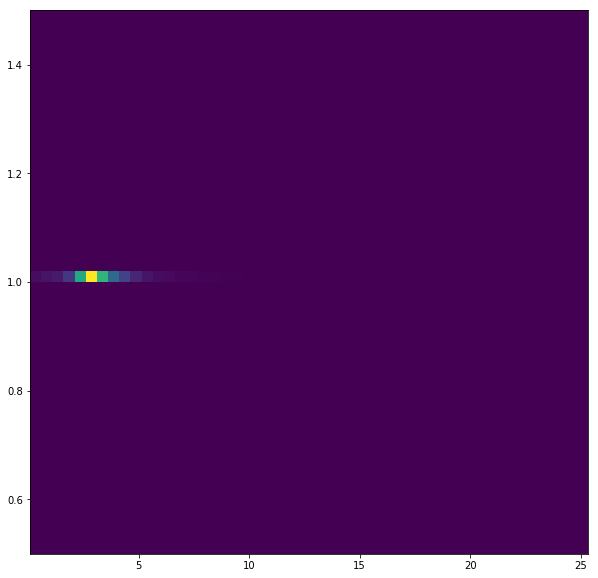

In [19]:
x_reg_test = vae.predict(x_test, batch_size = batch_size)

fig = plt.figure(14, figsize = (10,10))
plt.hist2d( x_test[:,0], x_reg_test[:,0], bins = 50)


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 35225.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
        0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92,
        0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14,
        1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36,
        1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ]),
 <a list of 50 Patch objects>)

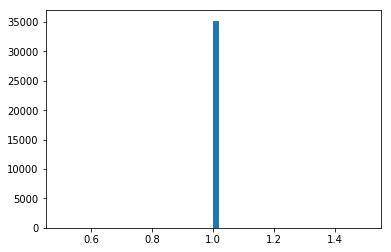

In [20]:
plt.hist( x_reg_test[:,0], bins = 50)


(array([3.4100e+02, 5.8900e+02, 7.5100e+02, 1.6420e+03, 6.2450e+03,
        1.0252e+04, 6.7600e+03, 3.5020e+03, 2.0880e+03, 1.0880e+03,
        5.6200e+02, 3.2700e+02, 2.4200e+02, 1.7000e+02, 1.4800e+02,
        8.7000e+01, 8.7000e+01, 7.0000e+01, 4.7000e+01, 3.8000e+01,
        2.8000e+01, 2.4000e+01, 1.8000e+01, 2.5000e+01, 1.2000e+01,
        1.2000e+01, 1.3000e+01, 8.0000e+00, 9.0000e+00, 6.0000e+00,
        5.0000e+00, 1.0000e+00, 7.0000e+00, 3.0000e+00, 5.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.09088472,  0.59578764,  1.10069057,  1.60559349,  2.11049641,
         2.61539934,  3.12030226,  3.62520519,  4.13010811,  4.63501104,
         5.13991396,  5.64481689,  6.14971981,  6.65462274,  7.15952566,
         7.66442859,  8.16933151,  8.67423444,  9.17913736,  9.68404029,
        10.18894321, 10.69

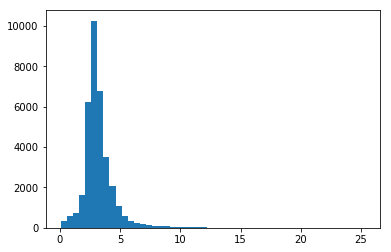

In [21]:
plt.hist( x_test[:,0], bins = 50)
